In [1]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
import pickle

# .py
sys.path.append("..")
from inference import GaussMarkovLagrange
from likelihoods import Gaussian
from mappings import AffineMapping
from transition import FixedPointSparseGP, SparseGP
from kernels import RBF
from models import GPSDEmodel, GPSDE
sys.path.append("../Data")
from Load_plot_data import load_neuron_data, roster_plot

## Load data and take its distribution

In [2]:
#Load data
ids,times=load_neuron_data('../Data/Cellline1_Date190328_Chip2135.npz')
N=np.max(ids) # Number of neurons

In [3]:
Yspike=[]
for i in range(N):
    Yspike.append(times[ids==i])
print(len(Yspike))


1016


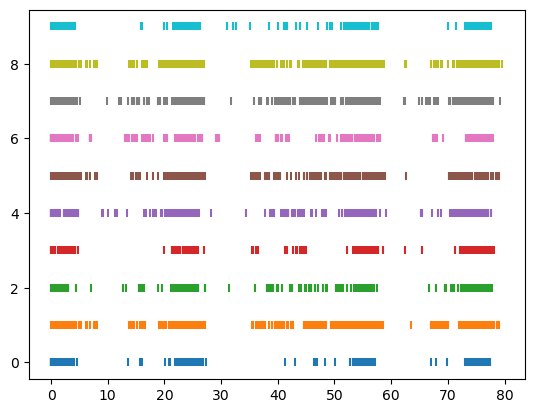

In [4]:
#Reduce the dataset (only one trial)
N=10
timemax=80

#Yspike=Yspike[0][:N] #keep only n first neuron

#seeds
torch.manual_seed(24)
np.random.seed(10) #C,d 
random.seed(26) #neuron choice

#keep n most actives
Yspike=sorted(Yspike,key=lambda x:x.shape[0],reverse=True)[:3*N]
#print(Yspike[-1].shape[0])
random.shuffle(Yspike) #There is a problem when just the N first are taken (not semidefinite positive qsigma)
Yspike=Yspike[:N]

#keep n not too actives but not 0
#Yspike=sorted(Yspike,key=lambda x:x.shape[0],reverse=True)
#print(Yspike[800].shape[0])
#random.shuffle(Yspike) #There is a problem when just the N first are taken (not semidefinite positive qsigma)
#Yspike=Yspike[:N]

for i in range(N):  #reduce the time
    Yspike[i]=Yspike[i][Yspike[i]<=timemax]
    plt.scatter(Yspike[i],i*np.ones(Yspike[i].shape[0]),marker='|')
plt.show()

In [5]:
def gaussian(x,sigma):
    """ delta_t represent the spacing between two histogram bins"""
    return 1./np.sqrt( 2. * np.pi * sigma**2 ) * np.exp( -x**2 / ( 2. * sigma**2 ) )

    

def spike_to_ditribution(Yspike,tmax,delta_t,sigma, kernel_size):
    """Yspike : list of array where array i contains the times at which neuron i had a spike"""
    new_data=[]
    nmb_bins=int(tmax/delta_t)
    for neuron in range(len(Yspike)):
        hist, bins=np.histogram(Yspike[neuron],bins=nmb_bins)
        Gaussian_filter=np.fromiter((gaussian(x,sigma) for x in (-kernel_size,kernel_size+1,1)),dtype=np.float64)
        
        Gaussian_filter= Gaussian_filter/( np.sum(Gaussian_filter) * delta_t )
        if np.sum(Gaussian_filter * delta_t) !=1:
            print( "not normalized")
            print(Gaussian_filter)

        Convolved_data=np.convolve(hist,Gaussian_filter,mode='same')
        Convolved_data[Convolved_data<=10**(-50)]=10**(-50)
        new_data.append(Convolved_data)
    
    return new_data,bins

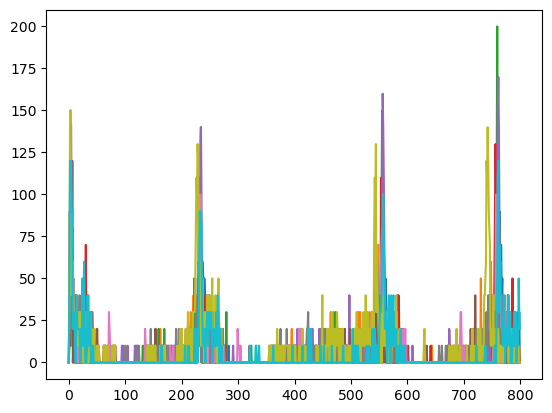

801
10
(800,)


In [6]:
sigma=0.1
delta_t=0.1

Yspike_distr,bins=spike_to_ditribution(Yspike,timemax,delta_t,sigma,5)
for spikeneuron in Yspike_distr:
    plt.plot(spikeneuron)
plt.show()
print(len(bins))
print(len(Yspike_distr))
print(Yspike_distr[0].shape)
#Yspike is a list of lenght N of array of shape timemax/delta_t

## Use a Gaussian model

In [7]:
from settings import float_type

Tmax=timemax
dtstep=0.1
Ybis=torch.Tensor(Yspike_distr).type(float_type).T
tObs=torch.Tensor(bins[:-1])
print(len(tObs))

nbins = int(Tmax / dtstep)
print(nbins)
nDims = Ybis.size(-1)
print(nDims)
obsMask = torch.histc(tObs, bins=nbins).type(torch.ByteTensor)
Ybin = torch.zeros(nbins, nDims).type(float_type)
print(obsMask.shape)
print(obsMask.unsqueeze(-1).shape)
print(obsMask.unsqueeze(-1).expand(Ybin.size()).shape)
print(Ybin.shape)
sh=Ybin[obsMask.unsqueeze(-1).expand(Ybin.size())].size()
print(sh)
Ybin[obsMask.unsqueeze(-1).expand(Ybin.size())] = Ybis.reshape(sh)

800
800
10
torch.Size([800])
torch.Size([800, 1])
torch.Size([800, 10])
torch.Size([800, 10])
torch.Size([8000])


C:\Users\fosmo\AppData\Local\Temp\ipykernel_5824\3905872109.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  Ybis=torch.Tensor(Yspike_distr).type(float_type).T
C:\Users\fosmo\AppData\Local\Temp\ipykernel_5824\3905872109.py:19: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  sh=Ybin[obsMask.unsqueeze(-1).expand(Ybin.size())].size()
C:\Users\fosmo\AppData\Local\Temp\ipykernel_5824\3905872109.py:21: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  Ybin[obsMask.unsqueeze(-1).expand(Ybin.size())] = Ybis.reshape(sh)


In [8]:
Y=[list(np.array(Yspike_distr).transpose())] #because of the trial and Y[] must be of shape (number sample, number neurons)
trLen=[timemax]
tObs=[bins[:-1]] # need to have len(tObs) >= Tmax / dtgrid

dtgrid =0.1 # time grid used for inference , need to be bigger than delta_t
xDim = 1       # latent dimensionality

C = 3.0*np.random.rand(N,1) * np.random.choice([-1,1],size=(N,1))
d = 0.1*np.random.randn(N,1)

R0 = 1. * torch.ones(N,1) # diagonal noise covariance of output 
like = Gaussian(Y, tObs, trLen, R0, dtstep=dtgrid, useClosedForm=True) # likelihood

# affine output mapping initialised at generative parameters (in example initialized with the true ones !)
outputMapping = AffineMapping(torch.tensor(C).permute(1, 0), torch.tensor(d).permute(1, 0), useClosedForm=True) 

# RBF kernel for the Gaussian Process prior, with lengthscales 
lens = torch.tensor([0.25]).reshape(-1,1).type(torch.float64)
kern = RBF(xDim,lens) 

xmax=3
numZ = 8 # number of inducing points 
Zs = torch.linspace(-xmax,xmax,numZ).unsqueeze(-1) # space inducing points on a grid
Zs_fx = torch.tensor([0.]).view(-1,xDim) # fixed point locations

# specify the transition function
#transfunc = SparseGP(kern, Zs) # vanilla sparse Gaussian Process transition function 
transfunc = FixedPointSparseGP(kern, Zs, Zs_fx) # sparse Gaussian Process transition function conditioned on fixed pts

# specify inference algorithm
inference = GaussMarkovLagrange(xDim, trLen, learningRate=0.1, dtstep=dtgrid)

# put everything tobgether into a model
model = GPSDEmodel(xDim, transfunc, outputMapping, like, nLeg=100)

# create GPSDE model object 
myGPSDE = GPSDE(model, inference)

c:\Users\fosmo\OneDrive\Documents\GitHub\gpsde\demos\..\utils.py:392: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  sh=Ybin[obsMask.unsqueeze(-1).expand(Ybin.size())].size()
c:\Users\fosmo\OneDrive\Documents\GitHub\gpsde\demos\..\utils.py:394: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  Ybin[obsMask.unsqueeze(-1).expand(Ybin.size())] = Y.reshape(sh) #changed to try making it work
c:\Users\fosmo\OneDrive\Documents\GitHub\gpsde\demos\..\transition.py:898: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_

In [9]:
# fix inducing points on a grid
myGPSDE.model.transfunc.Zs.requires_grad = False
# run EM iterations
myGPSDE.variationalEM(niter=6,eStepIter=3, mStepIter=3)

inference time=1.5078942775726318
nan value


RuntimeError: torch.linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 2 is not positive-definite).